In [11]:
# fill namespace with nupy and matplotlib + static notebook plots
%pylab inline
# fill namespace with nupy and matplotlib + and interactive plots
#%pylab notebook 
#%matplotlib qt
from __future__ import division # use so 1/2 = 0.5, etc.
import sk_dsp_comm.sigsys as ss
import sk_dsp_comm.digitalcom as dc
import sk_dsp_comm.rtlsdr_helper as sdr
import imp # for module reloading
import scipy.signal as signal
from IPython.display import Audio, display
from IPython.display import Image, SVG

Populating the interactive namespace from numpy and matplotlib


In [12]:
pylab.rcParams['savefig.dpi'] = 100 # default 72
#pylab.rcParams['figure.figsize'] = (6.0, 4.0) # default (6,4)
#%config InlineBackend.figure_formats=['png'] # default for inline viewing
%config InlineBackend.figure_formats=['svg'] # SVG inline viewing
#%config InlineBackend.figure_formats=['pdf'] # render pdf figs for LaTeX
#Image('fname.png',width='80%')

# Capture Broadcast FM and Demodulate
Using `rtlsdr_helper` record a short complex baseband array using `capture()`.

In [13]:
# From the docstring
#x = sdr.capture(Tc, fo=88700000.0, fs=2400000.0, gain=40, device_index=0)
x = sdr.capture(Tc=5,fo=89.5e6,fs=2.4e6,gain=40,device_index=0)

In [94]:
sdr.complex2wav('capture_989.wav',2400000,x)

Saved as binary wav file with (I,Q)<=>(L,R)


In [19]:
#'capture_989.wav'
fs, x = sdr.wav2complex('capture_989.wav')

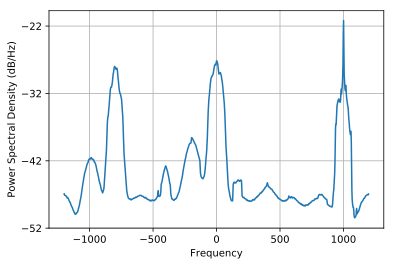

In [20]:
psd(x,2**10,2400);

## Mono

In [27]:
#'new_989_mono_demod.wav'
z_bb, z_demod = sdr.mono_FM(x,file_name='capture_989_mono.wav')

Done!


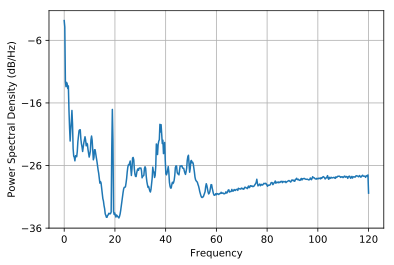

In [22]:
psd(z_bb,2**10,2400/10);

In [28]:
Audio('capture_989_mono.wav')

## Stereo
To recover the full stereo signal requires a bit more work.
### Recovering the 19 kHz Pilot Carrier
We investigate some of the options for obtaining a coherent carrier to demodulate the 38 kHz carrier. This allows the $L - R$ channel information to be obtained.

In [13]:
fs = 2400000
b = signal.firwin(64,2*200e3/float(fs))
# Filter and decimate (should be polyphase)
y = signal.lfilter(b,1,x)
z = ss.downsample(y,10)
# Apply complex baseband discriminator
z_bb = sdr.discrim(z)

In [38]:
z_bb19 = signal.lfilter(b19,1,z_bb)
theta, phi_error = sdr.pilot_PLL(z_bb19,19000,fs/10,2,100,0.707);

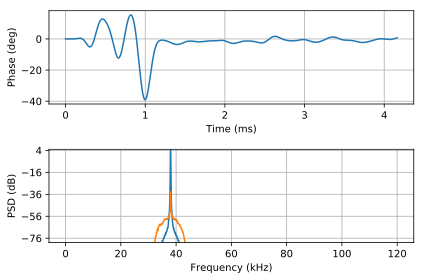

In [39]:
subplot(211)
plot(1000*arange(len(phi_error[:1000]))/(fs/10),phi_error[:1000]*180/pi)
ylabel(r'Phase (deg)')
xlabel(r'Time (ms)')
grid()
subplot(212)
psd(cos(2*theta),2**12,2400/10);
psd(signal.lfilter(b38,1,z_bb19**2),2**12,2400/10);
ylabel(r'PSD (dB)')
xlabel(r'Frequency (kHz)')
ylim([-80,5])
tight_layout()

#### Phase Jitter on the Recovered 19 kHz Pilot Carrier

In [40]:
var(phi_error[1000:])*180/pi

0.031397109138859486

### Designing Filters

In [26]:
import sk_dsp_comm.fir_design_helper as fir_d

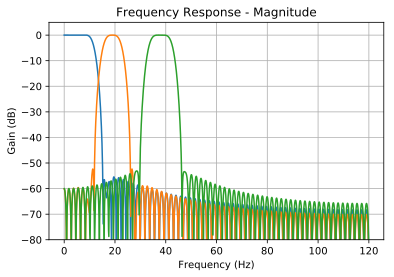

In [27]:
N1 = 10
# Lowpass
b12 = signal.firwin(128,2*12e3/(float(fs)/N1))
# Bandpass
b19 = signal.firwin(128,2*1e3*np.array([19-4,19+4])/(float(fs)/N1),
                        pass_zero=False);
# Bandpass
b38 = signal.firwin(128,2*1e3*np.array([38-5,38+5])/(float(fs)/N1),
                        pass_zero=False);
# PLot the frequency response of all three
fir_d.freqz_resp_list([b12,b19,b38],[1,1,1],'dB',2400/N1)
ylim([-80,5])
grid();

In [25]:
z_bb, theta, y_lpr, y_lmr, z_demod_stereo = \
                    sdr.stereo_FM(x,file_name='capture_989.wav')

Done!


In [29]:
Audio('capture_989.wav')

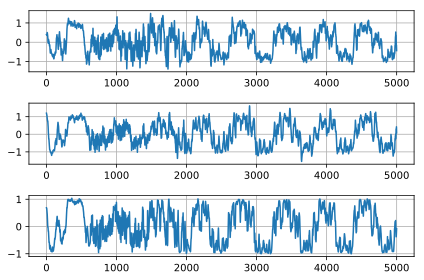

In [92]:
subplot(311)
#plot(y_lpr[130000:135000])
plot(z_demod_stereo[130000:135000,0])
# ylim([-.4,.4])
grid()
subplot(312)
#plot(y_lmr[130000:135000])
plot(z_demod_stereo[130000:135000,1])
# ylim([-.4,.4])
grid()
subplot(313)
plot(z_demod[130000:135000])
# ylim([-.4,.4])
grid()
tight_layout()